# DEAM Dataset - Feed Forward Neural Network
## Essentia Best All & openSMILE eGeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_all_opensmile_egemaps_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_all_opensmile_egemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_all_opensmile_egemaps_features = df_essentia_all_opensmile_egemaps_features[df_essentia_all_opensmile_egemaps_features.columns[1:]]

df_essentia_all_opensmile_egemaps_features

,song_id,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,2,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,3,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,4,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,5,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,7,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,1997,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,1998,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,1999,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [4]:
df_essentia_all_opensmile_egemaps_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 4602 columns):
 #     Column                                           Dtype  
---    ------                                           -----  
 0     song_id                                          int64  
 1     lowlevel.average_loudness                        float64
 2     lowlevel.barkbands_crest.dmean                   float64
 3     lowlevel.barkbands_crest.dmean2                  float64
 4     lowlevel.barkbands_crest.dvar                    float64
 5     lowlevel.barkbands_crest.dvar2                   float64
 6     lowlevel.barkbands_crest.max                     float64
 7     lowlevel.barkbands_crest.mean                    float64
 8     lowlevel.barkbands_crest.median                  float64
 9     lowlevel.barkbands_crest.min                     float64
 10    lowlevel.barkbands_crest.stdev                   float64
 11    lowlevel.barkbands_crest.var                     flo

Join both the featureset and annotation set together

In [5]:
df_essentia_all_opensmile_egemaps_whole = pd.merge(df_essentia_all_opensmile_egemaps_features, df_annotations, how='inner', on='song_id')
df_essentia_all_opensmile_egemaps_whole = df_essentia_all_opensmile_egemaps_whole.drop('song_id', axis=1)
df_essentia_all_opensmile_egemaps_whole

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,valence_mean_mapped,arousal_mean_mapped
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429,-0.475,-0.500
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348,-0.375,-0.425
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370,0.175,0.125
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132,-0.150,0.075
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006,-0.275,0.225
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482,0.075,-0.275
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258,0.350,0.300
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_all_opensmile_egemaps_features.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_crest.dmean,lowlevel.barkbands_crest.dmean2,lowlevel.barkbands_crest.dvar,lowlevel.barkbands_crest.dvar2,lowlevel.barkbands_crest.max,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.min,lowlevel.barkbands_crest.stdev,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0.972741,0.322732,0.345839,0.104501,0.145450,0.704285,0.376120,0.313025,0.154835,0.299859,...,0.351559,0.600638,0.181705,0.264131,0.049256,0.069750,0.164484,0.027513,0.014235,0.594429
1,0.583679,0.205943,0.227717,0.096043,0.121328,0.970572,0.702144,0.582300,0.362288,0.483374,...,0.126664,0.581319,0.212856,0.206415,0.329843,0.008219,0.024446,0.077423,0.056789,0.639348
2,0.990960,0.375110,0.387854,0.150212,0.190855,0.658252,0.336314,0.283905,0.164182,0.283623,...,0.273067,0.606355,0.358312,0.349895,0.314678,0.009789,0.018589,0.040617,0.018047,0.741370
3,0.914417,0.356523,0.363551,0.122697,0.149895,0.858083,0.392704,0.305499,0.277203,0.385212,...,0.573717,0.384170,0.228007,0.256759,0.041739,0.081478,0.149317,0.028571,0.018206,0.682132
4,0.991187,0.256914,0.255848,0.139336,0.149169,0.824768,0.660008,0.574646,0.183156,0.326380,...,0.264243,0.575046,0.362308,0.520714,0.060622,0.057195,0.142060,0.030864,0.021297,0.819566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.996544,0.532901,0.553871,0.245012,0.263674,0.717103,0.318415,0.236341,0.243114,0.343265,...,0.407510,0.426452,0.245619,0.619651,0.170727,0.020034,0.048555,0.024143,0.009844,0.640006
1740,0.998184,0.351222,0.382376,0.123357,0.160645,0.605959,0.307426,0.253574,0.218863,0.283298,...,0.409826,0.439188,0.155033,0.513858,0.144237,0.023835,0.051010,0.032222,0.021974,0.516482
1741,0.911413,0.423552,0.429467,0.174821,0.189958,0.795025,0.269332,0.218253,0.095981,0.334333,...,0.321734,0.510924,0.180579,0.506302,0.497215,0.005271,0.021518,0.045299,0.023471,0.599258
1742,0.974887,0.395791,0.436942,0.118189,0.156440,0.638507,0.285916,0.238424,0.279791,0.190968,...,0.384083,0.506933,0.183881,0.370283,0.413529,0.007011,0.014129,0.038426,0.021311,0.557897


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [12]:
num_epochs = 137

Set a random seed to ensure consistent initial weights of the neural network

In [13]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [15]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 4601])


Training loop

In [16]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [17]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5661834015323667
Epoch 2, Loss: 0.5626369415588923
Epoch 3, Loss: 0.5598375837203123
Epoch 4, Loss: 0.5578473579777717
Epoch 5, Loss: 0.5566148450804481
Epoch 6, Loss: 0.5561457257634804
Epoch 7, Loss: 0.556426505684494
Epoch 8, Loss: 0.5569106400769877
Epoch 9, Loss: 0.5570857894755818
Epoch 10, Loss: 0.5568954687498959
Epoch 11, Loss: 0.5564457066897077
Epoch 12, Loss: 0.5558247526622697
Epoch 13, Loss: 0.5550629594249218
Epoch 14, Loss: 0.5540614826603999
Epoch 15, Loss: 0.5524683065947233
Epoch 16, Loss: 0.5496887843738881
Epoch 17, Loss: 0.5449827700262395
Epoch 18, Loss: 0.538172969252933
Epoch 19, Loss: 0.529041214462359
Epoch 20, Loss: 0.5200428845530104
Epoch 21, Loss: 0.5167188601382692
Epoch 22, Loss: 0.5179622160670619
Epoch 23, Loss: 0.5144919170100595
Epoch 24, Loss: 0.5103382971667757
Epoch 25, Loss: 0.5027982669710171
Epoch 26, Loss: 0.5018779238167959
Epoch 27, Loss: 0.501730962490019
Epoch 28, Loss: 0.49972647397444503
Epoch 29, Loss: 0.49711141060414

Epoch 51, Loss: 0.46557154700668135
Epoch 52, Loss: 0.46206373890654306
Epoch 53, Loss: 0.46289489035914727
Epoch 54, Loss: 0.46318242979536806
Epoch 55, Loss: 0.4605155403536551
Epoch 56, Loss: 0.45984807016648593
Epoch 57, Loss: 0.460210582588931
Epoch 58, Loss: 0.45821213384099013
Epoch 59, Loss: 0.4576253371707661
Epoch 60, Loss: 0.45770263264919697
Epoch 61, Loss: 0.4562924927036441
Epoch 62, Loss: 0.4550329685318889
Epoch 63, Loss: 0.4549444599890082
Epoch 64, Loss: 0.454520608483011
Epoch 65, Loss: 0.45321596811000114
Epoch 66, Loss: 0.4526538372403444
Epoch 67, Loss: 0.4526574254572087
Epoch 68, Loss: 0.4518835556571032
Epoch 69, Loss: 0.4508633239710644
Epoch 70, Loss: 0.449812355920287
Epoch 71, Loss: 0.44902377665781934
Epoch 72, Loss: 0.4484207196701449
Epoch 73, Loss: 0.4481284801395904
Epoch 74, Loss: 0.44948213568186085
Epoch 75, Loss: 0.455756210251356
Epoch 76, Loss: 0.46232546335394215
Epoch 77, Loss: 0.4474555865683405
Epoch 78, Loss: 0.4538961622788181
Epoch 79, Los

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [18]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 4601])


Generating scores

In [19]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  # metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  # metric.update(test_pred, target_test_labels)
  # adjusted_r2_score = metric.compute()
  # print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [20]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.21112116739526332
Valence RMSE: 0.197782721122043
Arousal RMSE: 0.22366557596160783
Test R^2 score: tensor([0.5259, 0.5047], dtype=torch.float64)
Test R^2 score (overall): 0.5152923686522382


In [21]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_all_opensmile_egemaps_normalised.pt')

True values (test set)

In [21]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [22]:
test_pred

tensor([[ 1.1251e-01,  1.1965e-01],
        [-2.6359e-01, -3.3029e-01],
        [ 1.5169e-01,  1.4880e-01],
        [ 1.5888e-01,  1.5344e-01],
        [-1.0908e-01, -1.4203e-01],
        [-2.9090e-01, -3.6469e-01],
        [-4.6414e-01, -5.8547e-01],
        [ 1.5880e-01,  1.5339e-01],
        [-3.2098e-01, -4.0302e-01],
        [ 1.6056e-01,  1.5441e-01],
        [ 1.5392e-01,  1.5023e-01],
        [-1.7891e-01, -2.2407e-01],
        [-4.0625e-01, -5.1168e-01],
        [ 1.5809e-01,  1.5299e-01],
        [-2.1414e-02, -3.8488e-02],
        [-2.5645e-02, -4.3521e-02],
        [-3.9858e-01, -5.0193e-01],
        [-1.5185e-01, -1.9181e-01],
        [ 1.5707e-01,  1.5236e-01],
        [-3.3592e-01, -4.2207e-01],
        [-4.8604e-01, -6.1336e-01],
        [-2.6872e-01, -3.3676e-01],
        [-2.3645e-01, -2.9609e-01],
        [ 1.5495e-01,  1.5085e-01],
        [ 1.6138e-01,  1.5488e-01],
        [-1.2912e-01, -1.6534e-01],
        [ 1.6033e-01,  1.5429e-01],
        [ 1.3978e-01,  1.410

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [23]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [24]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5661834015323667
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3150954950457759
Test R^2 score: -0.08130789191335341
Num of epochs: 2
Epoch 1, Loss: 0.5661834015323667
Epoch 2, Loss: 0.5626369415588923
Training completed.
Training completed.
Testing model...
Test RMSE: 0.31090152245473723
Test R^2 score: -0.053207219358976876
Num of epochs: 3
Epoch 1, Loss: 0.5661834015323667
Epoch 2, Loss: 0.5626369415588923
Epoch 3, Loss: 0.5598375837203123
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3076213203079838
Test R^2 score: -0.031331766796814264
Num of epochs: 4
Epoch 1, Loss: 0.5661834015323667
Epoch 2, Loss: 0.5626369415588923
Epoch 3, Loss: 0.5598375837203123
Epoch 4, Loss: 0.5578473579777717
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3051880822787037
Test R^2 score: -0.015236610982118481
Num of epochs: 5
Epoch 1, Loss: 0.5661834015323667
Epoch 2, Loss: 0.5626369415588923
Epoch 3

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [25]:
import matplotlib.pyplot as plt

In [26]:
r2_scores_list

[-0.08130789191335341,
 -0.053207219358976876,
 -0.031331766796814264,
 -0.015236610982118481,
 -0.00444679250162916,
 0.00018785050973924022,
 0.000948174097381127,
 0.0011356302631368997,
 0.0023032763847067317,
 0.004427031657866343,
 0.0073639977343665786,
 0.011077887625765004,
 0.016592852133862634,
 0.027130840133325007,
 0.047955824661566115,
 0.08474059205313716,
 0.13676852576280407,
 0.1990980567803159,
 0.2609027919615022,
 0.2722639019415289,
 0.25464274609303456,
 0.2763147234406286,
 0.28620327135508106,
 0.339758459892728,
 0.35266620150637,
 0.33341686591484654,
 0.34499248048582837,
 0.3738030940355503,
 0.38672828782295,
 0.3759666488540271,
 0.3904894812551848,
 0.38771327813080425,
 0.36587906118287705,
 0.40021558430218834,
 0.41572831663141363,
 0.3962113919532084,
 0.42269671264603004,
 0.4384114414328082,
 0.4172805607293688,
 0.4228420713801373,
 0.44096051096622085,
 0.40425046479860566,
 0.42099331093842857,
 0.4494475292540413,
 0.4180059898035685,
 0.44728

Plot the line graph

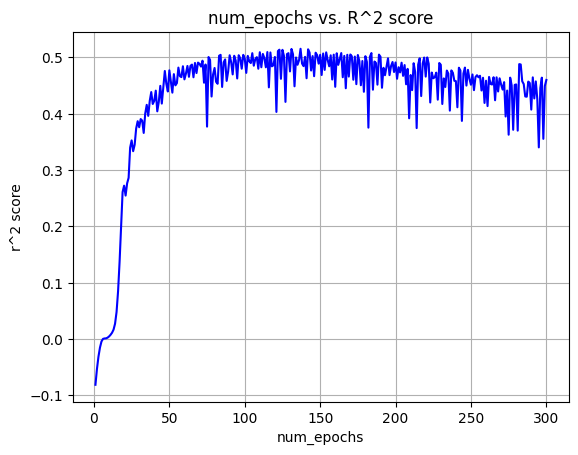

In [27]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [28]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5152923686522382
Corresponding RMSE: 0.21112116739526332
Corresponding num_epochs: 137
